#Libraries

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications.vgg19 import preprocess_input

In [2]:
# Import packages
import os
import cv2
import imutils

import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score

#Setup datasets

In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the dataset
IMG_PATH = '/content/drive/MyDrive/brain_tumor_dataset/'

# Create a list of all the image filenames
all_images = []
for folder in ['yes', 'no']:
    folder_path = os.path.join(IMG_PATH, folder)
    for filename in os.listdir(folder_path):

         all_images.append(os.path.join(folder_path, filename))

# Create a list of corresponding labels (0 for 'no', 1 for 'yes')
labels = [1 if 'Y' in filename else 0 for filename in all_images]

# Split the dataset into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(all_images, labels, test_size=0.03, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=123)

# Print the sizes of the resulting datasets
print(f'Train set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Test set size: {len(X_test)}')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train set size: 183
Validation set size: 62
Test set size: 8


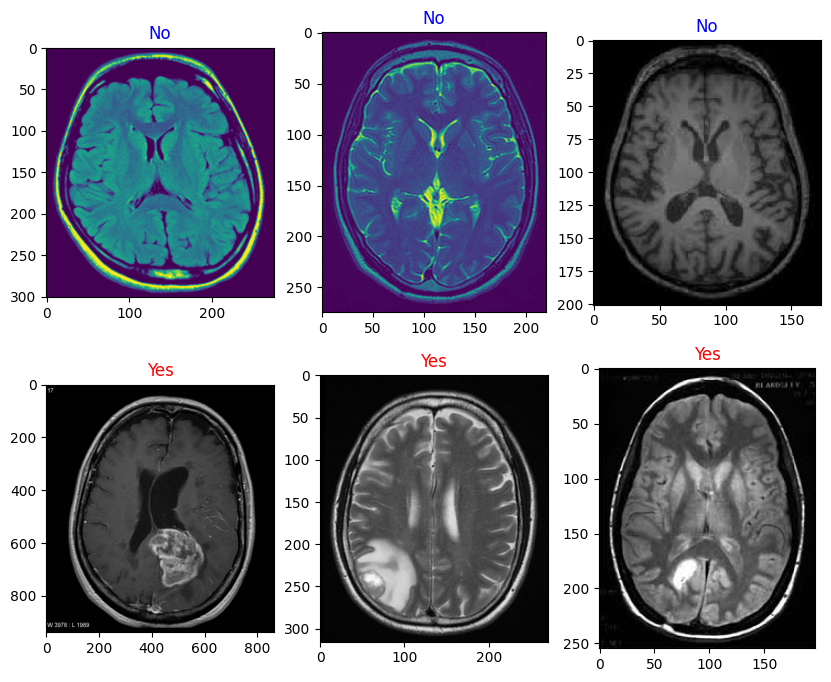

In [4]:

%matplotlib inline

# Define the labels and their corresponding colors
labels = {0: 'No', 1: 'Yes'}
colors = {0: 'blue', 1: 'red'}

# Plot some images from the train set for each label
fig, axs = plt.subplots(2, 3, figsize=(10, 8))
for i, label in enumerate([0, 1]):
    images = [x for x, y in zip(X_train, y_train) if y == label][:3]
    for j, image_path in enumerate(images):
        img = plt.imread(image_path)
        axs[i, j].imshow(img)
        axs[i, j].set_title(labels[label], color=colors[label])
plt.show()

#Data pre-processing

In [5]:
def preprocess_images(images):
    preprocessed_images = []
    for i, img_path in enumerate(images):
        img = cv2.imread(img_path)
        img = cv2.resize(
            img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC
        )
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        # crop
        ADD_PIXELS = 0
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        new_img = cv2.resize(
            new_img,
            dsize=(224,224))
        preprocessed_images.append(new_img)
    return np.array(preprocessed_images)

In [6]:
# Apply the preprocessing to all the data subsets
X_train_pre = preprocess_images(X_train)
X_val_pre = preprocess_images(X_val)
X_test_pre = preprocess_images(X_test)

In [9]:
# Transform the subsets to numpy arrays
X_train_pre = np.array([preprocess_input(image) for image in X_train_pre])
X_val_pre = np.array([preprocess_input(image) for image in X_val_pre])
X_test_pre = np.array([preprocess_input(image) for image in X_test_pre])

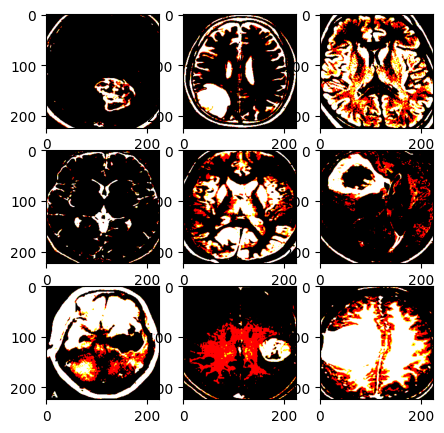

In [10]:
# plot some images from X_train_pre
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train_pre[i], cmap='gray')
plt.show()

#Train Model

In [11]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Convert labels to numpy array for fitting
import numpy as np
y_train = np.array(y_train)
y_val = np.array(y_val)

# Train the model
history = model.fit(
    x=np.array(X_train_pre),
    y=y_train,
    epochs=10,
    batch_size=32,
    validation_data=(np.array(X_val_pre), y_val)
)

# Save the model
model.save('/content/drive/MyDrive/brain_tumor_classifier.h5')

Epoch 1/10
6/6 [==============================] - 58s 9s/step - loss: 1.6232 - accuracy: 0.6503 - val_loss: 1.0606 - val_accuracy: 0.7258
Epoch 2/10
6/6 [==============================] - 62s 11s/step - loss: 0.4601 - accuracy: 0.8525 - val_loss: 0.3721 - val_accuracy: 0.8387
Epoch 3/10
6/6 [==============================] - 59s 10s/step - loss: 0.2313 - accuracy: 0.9126 - val_loss: 0.4072 - val_accuracy: 0.9032
Epoch 4/10
6/6 [==============================] - 58s 10s/step - loss: 0.1684 - accuracy: 0.9399 - val_loss: 0.3499 - val_accuracy: 0.7903
Epoch 5/10
6/6 [==============================] - 59s 10s/step - loss: 0.1163 - accuracy: 0.9508 - val_loss: 0.2694 - val_accuracy: 0.9194
Epoch 6/10
6/6 [==============================] - 53s 9s/step - loss: 0.0769 - accuracy: 0.9727 - val_loss: 0.2664 - val_accuracy: 0.8548
Epoch 7/10
6/6 [==============================] - 58s 10s/step - loss: 0.0673 - accuracy: 0.9836 - val_loss: 0.1956 - val_accuracy: 0.9032
Epoch 8/10
6/6 [=============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#Evaluation

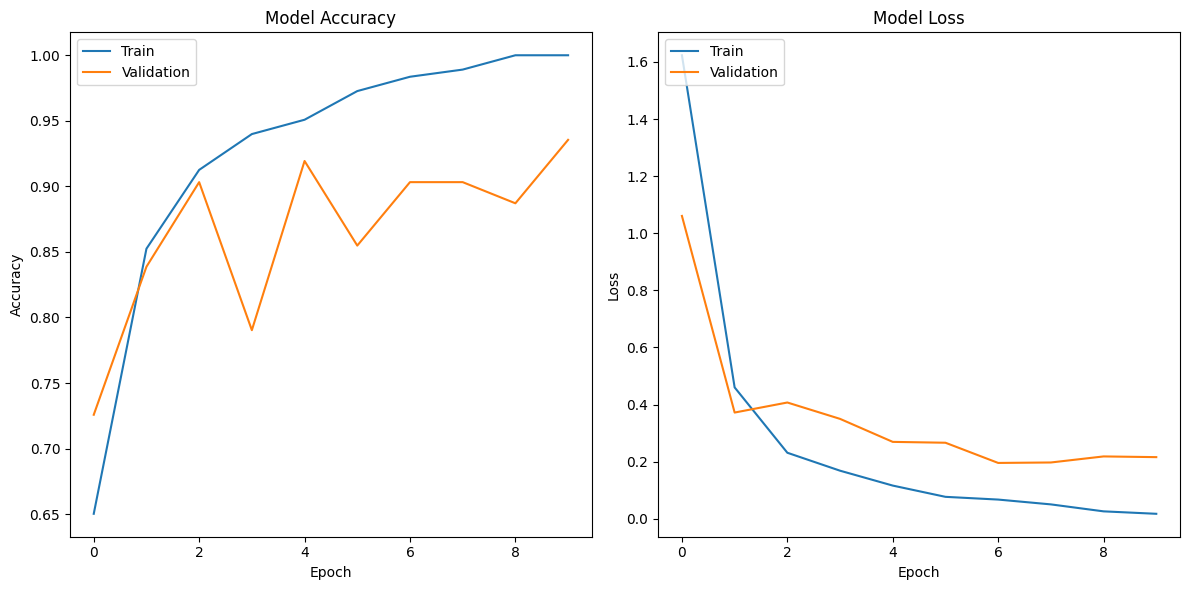

1/1 [==============================] - 1s 1s/step - loss: 0.3833 - accuracy: 0.7500
Test Accuracy: 0.75


In [12]:
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(np.array(X_test_pre), np.array(y_test))
print("Test Accuracy:", test_acc)
